
# Product application in 3D

## Algorithm to generate 3D mesh from extrusion profile and arbitrary polygon

The input polygon that we want to cover with 3D tiles needs to be:
 - simple
 - planar

Base of the idea is in establishing TBN space, defined by (t)angent, (b)itangent and (n)ormal vector of the input polygon. In this space we can align the (repeated) 2D profile to the top (start) and bottom (end) edge of the polygon's bounding box. These two paths are then bridged to create a quad-mesh. This mesh is then clipped to the original polygon using quasi-CSG operations.

Notebook requirements:
 * Jupyter lab
 * numpy, scipy, ipywidgets
 * pythreejs (both the package and the lab extension)
 * cython-csg
 

### Imports and basic tools

In [1]:
import random
import numpy as np
from math import pi, ceil, floor
from scipy.linalg import expm, norm
from scipy.spatial import Delaunay
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

EPS = 1e-5

def poly_normal(poly):
    a, b, c = poly[:3]
    x = np.linalg.det([[1,a[1],a[2]],
             [1,b[1],b[2]],
             [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
             [b[0],1,b[2]],
             [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
             [b[0],b[1],1],
             [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

def poly_area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(poly)
    for i in range(N):
        vi1 = poly[i]
        vi2 = poly[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, poly_normal(poly[0], poly[1], poly[2]))
    return result/2

def normalize(v):
    return v/np.linalg.norm(v)

### Display functions

In [2]:
from collections import namedtuple
from pythreejs import *
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
from matplotlib.colors import to_hex

Face3D = namedtuple('Face', [
    'a','b','c',
    'normal','color','materialIndex'
])

Bounds = namedtuple('Bounds', [
    'min', 'max', 'size', 'center', 'mag'
])

W = 600
H = 400

def bounds(position):
    bmin = np.min(position, axis=0)
    bmax = np.max(position, axis=0)
    bext = bmax - bmin
    bmag = np.max(bext)
    bctr = bmin + bext*0.5
    return Bounds(
        min=bmin, max=bmax, size=bext, center=bctr, mag=bmag)

def make_scene(*args):
    scene = Scene(children=[
        DirectionalLight(
            color="#ffffff",
            position=[3,5,1],
            intensity=1.0),
        AmbientLight(
            color="#ffffff",
            intensity=0.3),
        GridHelper(15,15),
        AxesHelper(1)
    ])
    for x in args:
        scene.add(x)
    return scene

def display_poly2D(poly):
    p = pltpat.Polygon(poly, closed=False)
    ax = plt.gca()
    ax.add_patch(p)
    bmin = np.min(poly, axis=0)
    bmax = np.max(poly, axis=0)
    ax.set_xlim(bmin[0]-1, bmax[0]+1)
    ax.set_ylim(bmin[1]-1, bmax[1]+1)
    plt.show()

def poly_to_mesh(position, indices, color, opacity=1):
    geom = Geometry()
    geom.vertices = position
    geom.faces = [
        Face3D(a=a, b=b, c=c, 
             normal=poly_normal([
                 position[a],
                 position[b],
                 position[c]
             ]), 
             color=(1,1,1), 
             materialIndex=0)
        for a, b, c in indices]
    mtl = MeshStandardMaterial(
        color=to_hex(color),
        metallicity=0,
        roughness=1,
        opacity=opacity,
        transparent=True,
        side='DoubleSide')
    return Mesh(geom, mtl), bounds(position)

def mesh_renderer(mesh, bbox):
    scene = make_scene(mesh)
    camera = PerspectiveCamera(
        position=[1,1,1], up=[0,1,0], aspect=W/H)
    camera.position = tuple(bbox.center + [0, bbox.mag/2, bbox.mag])
    ctrl = OrbitControls(
        controlling=camera, 
        target=tuple(bbox.center))
    ctrl.exec_three_obj_method('update')
    
    return Renderer(
        width=W, height=H,
        camera=camera, scene=scene, controls=[ctrl])
    
# display(
#     mesh_renderer(
#         *poly_to_mesh(
#             [[0,0,0], [1,0,0], [1,0,-1], [0,0,-1]], 
#             [[0,1,2],[0,2,3]],
#             (1,0,0))))

### Define input polygon

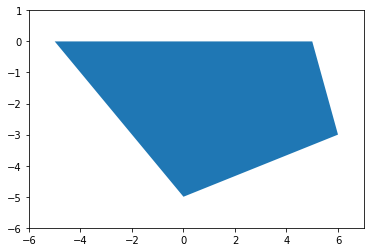

In [3]:
# Start in XZ plane
face_xz = np.array([
    [-5, 0,  0],
    [ 5, 0,  0],
    [ 6, 0, -3],
    [ 0, 0, -5]
])
face_xz_2D = face_xz[:,[0,2]]

display_poly2D(face_xz_2D)

### Bring it to 3D

In [4]:
import random

def rotate(axis, theta):
    return expm(np.cross(np.eye(3), axis/norm(axis)*theta))

tf = np.dot(
    # rotate on Y axis by 90 deg.
    rotate([0,1,0], random.uniform(-pi/2, pi/2)), 
    # rotate on X axis by n deg.
    rotate([1,0,0], random.uniform(0, pi/4))
)
tf_inv = np.linalg.inv(tf)

face = tf.dot(face_xz.T).T
face_indices = Delaunay(face_xz_2D).simplices

In [5]:
display(mesh_renderer(*poly_to_mesh(face.tolist(), face_indices, (1,0.5,1))))

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

### Find basis for surface tangent space

Following doesn't work well for polygons aligned to XZ plane, ie. when the normal is the same as the "projection" vector, which in our "common" case is the up-vector.

In [6]:
def poly_basis(p, poly):
    n = poly_normal(poly)
    t = np.cross(p, n)
    if np.linalg.norm(t) < EPS:
        # colinear normal with projection, this could be
        # some "base edge" if known
        t = np.array([1, 0, 0])
    else:
        t = normalize(t)
    b = normalize(np.cross(t, n))
    return [t, b, n]

basis = poly_basis([0,1,0], face)

In [7]:
RGB = [(1,0,0),(0,1,0),(0,0,1)]

def basis_helpers_rgb(origin, t, b, n):
    return [
        ArrowHelper(
            origin=origin, dir=tuple(v), 
            color=to_hex(RGB[i]), headWidth=0.2)
        for i, v in enumerate([t, b, n])]

def basis_helpers(origin, color, t, b, n):
    return [
        ArrowHelper(
            origin=origin, dir=tuple(v), 
            color=color, headWidth=0.2)
        for i, v in enumerate([t, b, n])]

def basis_renderer(origin, opacity=1):
    renderer = mesh_renderer(*poly_to_mesh(face.tolist(), face_indices, (1,0.5,1), opacity))
    for h in basis_helpers_rgb(origin, *basis):
        renderer.scene.add(h)
    return renderer

origin = tuple(tf.dot(bounds(face_xz).center+[0,0.01,0]))
display(basis_renderer(origin))

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

### Find extrusion origin

We need to find an origin point where we can place the 2D profile to be extruded, as well as extrusion axis (the profile will be oriented perpendicular to the extrusion axis).

To do this, we transform the face into tangent space using TBN (tangent, bitangent, normal) matrix, and then take the min of its bounding box. This is then transformed using inverse TBN matrix back to world space.

In [8]:
TBN = np.array(basis)
TBN_inv = np.linalg.inv(TBN)
face_tbn = TBN.dot(face.T).T
ext_origin = TBN_inv.dot(np.min(face_tbn, axis=0))

In [9]:
def tbn_and_origin_renderer():
    mesh, _ = poly_to_mesh(face_tbn.tolist(), face_indices, (0,1,1), 0.5)
    renderer = basis_renderer(ext_origin.tolist(), opacity=0.5)
    renderer.scene.add(mesh)
    return renderer

display(tbn_and_origin_renderer())

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

### Define 2D profile curve

This will be specified on input, such as a path from SVG source.

In [10]:
profile = np.array([
    [0.0, 0.2],
    [1.0, 0.2],
    [1.1, 0.5],
    [1.9, 0.5],
    [2.0, 0.2]
], dtype=np.float32)
profile_bounds = bounds(profile)
unit_profile = (profile - profile_bounds.min) / profile_bounds.size[0]

(-0.29999999701976776, 1.0)

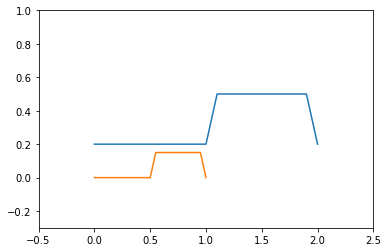

In [11]:
plt.plot(profile[:,0], profile[:,1])
plt.plot(unit_profile[:,0], unit_profile[:,1])
plt.xlim(profile_bounds.min[0]-0.5, profile_bounds.max[0]+0.5)
plt.ylim(profile_bounds.min[1]-0.5, profile_bounds.max[1]+0.5)

### Transform and extend the profile

- Such that its origin aligns with extrusion origin and basis vectors.
- Such that the paths is repeated the cover the face in tangent direction.

In [12]:
unit_profile_3D = TBN_inv.dot(np.insert(unit_profile, 1, values=0, axis=1).T).T + ext_origin
nrep = ceil(bounds(face_tbn).size[0])

def repeat_path(path, nrep):
    step = bounds(path).size[0]
    vertices = np.empty((0, path.shape[1]))
    offset = 0
    for i in range(nrep):
        offset_vertices = path + [offset, 0]
        if len(vertices) > 0 and np.linalg.norm(offset_vertices[0] - vertices[-1]) < EPS:
            vertices = np.concatenate((vertices, offset_vertices[1:]), axis=0)
        else:
            vertices = np.concatenate((vertices, offset_vertices), axis=0)
        offset += step
    return np.array(vertices)

profile_ext = TBN_inv.dot(
    np.insert(
        repeat_path(unit_profile, nrep), 
        1, values=0, axis=1).T
).T + ext_origin

In [13]:
def profile_geom(path, width, offset=[0,0,0]):
    nrep = ceil(bounds(face_tbn).size[0]/width)
    single_profile = path*width
    retpath = TBN_inv.dot(
        np.insert(
            repeat_path(single_profile, nrep), 
            1, values=0, axis=1).T
    ).T + ext_origin + offset
    return BufferGeometry(
        attributes={
            'position': BufferAttribute(retpath.astype(np.float32))
        }, normalized=False)
    
def profile_mesh(path, width, offset=[0,0,0], color="#ff0000"):
    geom = profile_geom(path, width, offset)
    mtl = LineBasicMaterial(color=color)
    return Line(geom, mtl)

def profile_renderer(path, width):
    mesh = profile_mesh(path, width)
    renderer = mesh_renderer(
        *poly_to_mesh(face.tolist(), face_indices, (1,0.5,1), 
                      opacity=0.75))
    for h in basis_helpers(ext_origin.tolist(), "#cccccc", *basis):
        renderer.scene.add(h)
    renderer.scene.add(mesh)
    return renderer, mesh

def run_profile_renderer():
    renderer, mesh = profile_renderer(unit_profile, 1.0)
    def update_profile_renderer(width):
        mesh.geometry.exec_three_obj_method('dispose')
        mesh.geometry = profile_geom(unit_profile, width['new'])
    width = widgets.FloatSlider(min=0.25, max=3.0, step=0.01, value=1.0)
    width.observe(update_profile_renderer, 'value')
    display(widgets.HBox(children=[
        widgets.Label("Width :"),
        width]))
    display(renderer)

run_profile_renderer()

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

Next, create the other end of the extrusion by offseting the base along bitangent vector, by the Y extent in TBN space:

In [14]:
extrusion_length = bounds(face_tbn).size[1]
profile_ext_end = profile_ext + basis[1]*extrusion_length

In [15]:
def extrusion_end_renderer(path, width):
    renderer, start = profile_renderer(path, width)
    end = profile_mesh(path, width, basis[1]*extrusion_length, "#0000ff")
    renderer.scene.add(end)
    return renderer, start, end

def run_extrusion_end_renderer(width):
    renderer, start, end = extrusion_end_renderer(unit_profile, width)
    def update_renderer(width):
        start.geometry.exec_three_obj_method('dispose')
        start.geometry = profile_geom(unit_profile, width['new'])
        end.geometry.exec_three_obj_method('dispose')
        end.geometry = profile_geom(unit_profile, width['new'], basis[1]*extrusion_length)
    wwidth = widgets.FloatSlider(min=0.25, max=3.0, step=0.01, value=width)
    wwidth.observe(update_renderer, 'value')
    display(widgets.HBox(children=[
        widgets.Label("Width :"),
        wwidth]))
    display(renderer)

run_extrusion_end_renderer(1.0)

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

### Bridge start and end paths to create triangle mesh

In [16]:
def edges(path):
    """ Generate edges from path vertices """
    for i in range(0, len(path)-1):
        yield path[i:i+2]

def bridge_quads(start, end):
    """ Bridge two paths, generating quads """
    for [s0, s1], [e0, e1] in zip(edges(start), edges(end)):
        yield [s0, s1, e1, e0]

def bridge_tris(start, end):
    """ Bridge two paths, generating triangles """
    for a, b, c, d in bridge_quads(start, end):
        yield [a, b, c]
        yield [a, c, d]
        
def bridge_faces():
    return bridge_quads(profile_ext_end, profile_ext)

In [17]:
def faces_to_mesh(faces):
    geom = BufferGeometry(
        attributes={
            'position': BufferAttribute(faces.astype(np.float32))
        })
    geom.exec_three_obj_method('computeVertexNormals')
    return geom

def face_outline(path):
    line = np.copy(path).tolist()
    line.append(line[0])
    return BufferGeometry(
        attributes={
            'position': BufferAttribute(np.array(line, dtype=np.float32))
        }, normalized=False)

def bridge_renderer(start, end):
    renderer, _, _ = extrusion_end_renderer(unit_profile, 1.0)
    renderer.scene.remove(renderer.scene.children[4])
    geom = faces_to_mesh(np.array(list(bridge_tris(end, start))))
    mtl = MeshStandardMaterial(
        color="#66ffff", 
        opacity=0.8, 
        transparent=True,
        side='DoubleSide')
    mesh = Mesh(geom, mtl)
    renderer.scene.add(mesh)
    geom = face_outline(face)
    mtl = LineBasicMaterial(color="#000000")
    mesh = Line(geom, mtl)
    renderer.scene.add(mesh)
    return renderer
    
display(bridge_renderer(profile_ext, profile_ext_end))

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

### Clip generated faces using input face

Polygon clipping is a big problem on its own, we need to use external library to save time. Here we are using [Cython CSG](https://github.com/tomturner/cython-csg) library for Python, it's an optimized port if PyCSG library by Tim Knip, which is a port of [csg.js](https://evanw.github.io/csg.js/) library by Evan W. 

In [18]:
from _cython_csg import CSG, BSPNode, Polygon, Vertex

In [19]:
def polys_to_csg(polys):
    """ Convert sequence of polygons into CSG object """
    return CSG.fromPolygons([
        Polygon([Vertex([x, y, z]) for x, y, z in poly])
        for poly in polys
    ])

def poly_to_clipping_csg(poly, n, offset=100):
    """ Create clipping CSG object by extruding sides of the polygon
    along the vector n """
    noff = n*offset
    def make_side(a, b):
        return [
            a - noff,
            b - noff,
            b + noff,
            a + noff
        ]
    return polys_to_csg([
        make_side(a, b) for a, b in edges(np.concatenate((poly, [poly[0]])))
    ])

def csg_to_polys(csg):
    """ Convert CSG object to polygon sequence """
    return [
        np.array([[p.pos.x, p.pos.y, p.pos.z] for p in poly.vertices])
        for poly in csg.toPolygons()
    ]

def clip(A, B):
    """ Custom clipping operation based on BSP tree node operations """
    a = BSPNode(A.clone().polygons)
    b = BSPNode(B.clone().polygons)
    b.invert()
    a.clipTo(b)
    return CSG.fromPolygons(a.allPolygons())

bridge_csg = polys_to_csg(bridge_faces())
clipping_csg = poly_to_clipping_csg(face, TBN[2])
clipped_polys = csg_to_polys(clip(bridge_csg, clipping_csg))

def triangulate3(poly):
    """ Triangulate 3D polygon by first transforming it into XY plane,
    and then computing Dealaunay triangulation. """
    tbn = np.array(poly_basis([0,0,1], poly))
    poly_tbn = tbn.dot(poly.T).T[:,[0,1]]
    indices = Delaunay(poly_tbn).simplices
    return poly[indices]
    
clipped_tris = np.concatenate(
    [triangulate3(face) for face in clipped_polys], axis=0)


In [20]:
def csg_result_renderer():
    renderer, _, _ = extrusion_end_renderer(unit_profile, 1.0)
    renderer.scene.remove(renderer.scene.children[4])
    geom = faces_to_mesh(clipped_tris)
    mtl = MeshStandardMaterial(
        color="#66ffff", 
        opacity=0.8, 
        transparent=True,
        side='DoubleSide')
    mesh = Mesh(geom, mtl)
    renderer.scene.add(mesh)
    geom = face_outline(face)
    mtl = LineBasicMaterial(color="#000000")
    mesh = Line(geom, mtl)
    renderer.scene.add(mesh)
    return renderer
    
display(csg_result_renderer())

Renderer(camera=PerspectiveCamera(aspect=1.5, position=(-1.8735587450117768, 6.894156878209674, 10.57629092906…

# The End